In [192]:
import json
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import Dataset, DataLoader
from pathlib import Path

In [254]:
# Importing the dataset.
# The LIDAR server produces samples at 30Hz with object positions normalized in their
# space, i.e. x and y values are in the 0-1 range.
datadir = Path("../testdata")
names = [
    "dump-1731964073793.jsonl",
    "dump-1731965089198.jsonl",
    "dump-1731966752296.jsonl",
    "dump-1732220377000.jsonl",
    "dump-1732378712139.jsonl"
]

data = []
for name in names:
    path = datadir.joinpath(datadir, name)
    f = open(path, 'r')
    last_is_zero = False
    points = []
    for line in f.readlines():
        d = json.loads(line)
        if d['type'] != 'object':
            continue
        payload = d['payload']
        # At the beginning and end of the session there is nobody on stage and
        # there are many 0,0 points.
        is_zero = payload['x'] == 0 and payload['y'] == 0
        if is_zero:
            continue
            
        points.append({
            'x': payload['x'],
            'y': payload['y'],
        })
    data.append(points)

In [255]:
class SequenceToSequenceDataset(Dataset):
    # Instead of predicting the next point, we make the network predict
    # the next trajectory. This way, it will be forced to imitate the
    # behaviour of the training setup.
    def __init__(self, data, sequence_length=90):
        self.sequence_length = sequence_length

        for points in data:     
            # Convert data to numpy array
            xy_points = np.array([[d['x'], d['y']] for d in points])
        
            # Create sequences
            self.sequences = []
            self.targets = []
        
            for i in range(len(xy_points) - (sequence_length * 2)):
                start = i
                mid = i + sequence_length
                end = mid + sequence_length
            
                self.sequences.append(xy_points[start:mid])
                self.targets.append(xy_points[mid:end])
    
    def __len__(self):
        return len(self.sequences)
    
    def __getitem__(self, idx):
        return torch.as_tensor([self.sequences[idx], self.targets[idx]], dtype=torch.float32)

In [256]:
# Checking that the dataset works.
dataset = SequenceToSequenceDataset(data)
next(iter(dataset)).shape

torch.Size([2, 90, 2])

In [257]:
class TrajectoryPredictor(nn.Module):
    def __init__(self, input_dim=2, hidden_dim=128, lstm_layers=3, dense_layers=[64, 32, 16], output_dim=2):
        super(TrajectoryPredictor, self).__init__()
        
        # LSTM layers for temporal processing
        self.lstm = nn.LSTM(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=lstm_layers,
            batch_first=True
        )
        
        # Fully connected layers for further feature processing
        dense_layers_list = []
        input_size = hidden_dim
        for layer_size in dense_layers:
            dense_layers_list.append(nn.Linear(input_size, layer_size))
            dense_layers_list.append(nn.ReLU())
            input_size = layer_size
        self.fc = nn.Sequential(*dense_layers_list)
        
        # Output layer with Sigmoid activation
        self.output_layer = nn.Linear(input_size, output_dim)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        # x: (batch_size, input_sequence_length, input_dim)
        lstm_out, _ = self.lstm(x)  # lstm_out: (batch_size, input_sequence_length, hidden_dim)
        dense_out = self.fc(lstm_out)  # Pass each timestep's hidden state through dense layers
        output = self.sigmoid(self.output_layer(dense_out))  # Output: (batch_size, input_sequence_length, output_dim)
        return output

In [252]:
# Checking that the model works
model = TrajectoryPredictor()
with torch.no_grad():
    dummy_input = torch.rand(1, 5, 2)
    # Forward pass
    output = model(dummy_input)
    print(output) 

tensor([[[0.5558, 0.5719],
         [0.5559, 0.5719],
         [0.5560, 0.5719],
         [0.5560, 0.5719],
         [0.5561, 0.5719]]])


In [302]:
# Training
from accelerate import Accelerator
import torch
import shutil
import os
import torch.nn as nn
import torch.optim as optim
from datetime import datetime
from tqdm import tqdm
from torch.utils.data import DataLoader, random_split
import wandb

# Initialize Accelerator
accelerator = Accelerator()

current_date = datetime.now().strftime("%Y-%m-%d")
num_epochs = 100
patience = 20  # Early stopping patience
best_val_loss = float("inf")
epochs_without_improvement = 0
best_path = ""

# Hyperparams
lr = 1e-3
sequence_length=60
hidden_dim=128
lstm_layers=3
dense_layers=[128, 64, 32, 16]
batch_size = 32

# Initialize the dataset
dataset = SequenceToSequenceDataset(data, sequence_length=sequence_length)

# Define split ratios
train_ratio = 0.8
val_ratio = 0.2

# Compute split sizes
dataset_size = len(dataset)
train_size = int(train_ratio * dataset_size)
val_size = dataset_size - train_size

# Split dataset
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Create DataLoaders

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Define model, optimizer, and loss function
model = TrajectoryPredictor(hidden_dim=hidden_dim, lstm_layers=lstm_layers, dense_layers=dense_layers)

optimizer = optim.Adam(model.parameters(), lr=lr)
loss_fn = nn.MSELoss()  # Mean Squared Error for position regression

# Prepare everything with Accelerate
model, optimizer, train_loader, val_loader = accelerator.prepare(
    model, optimizer, train_loader, val_loader
)

run = wandb.init(
    # set the wandb project where this run will be logged
    project="afterlife",

    # track hyperparameters and run metadata
    config={
    "learning_rate": lr,
    "architecture": "LSTM",
    "dataset": "MAX",
    "epochs": num_epochs,
    "sequence_length":sequence_length,
    "hidden_dim": hidden_dim,
    "lstm_layers": lstm_layers,
    "dense_layers": dense_layers,
    "batch_size": batch_size
    }
)

for epoch in range(num_epochs):
    # Training phase
    model.train()
    train_loss = 0.0
    for batch in tqdm(train_loader, desc=f"Epoch {epoch + 1}/{num_epochs} - Training"):
        inputs, targets = batch[:, 0], batch[:, 1]

        optimizer.zero_grad()
        outputs = model(inputs)  # Forward pass
        loss = loss_fn(outputs, targets)  # Compute loss
        accelerator.backward(loss)  # Backpropagation using Accelerate
        optimizer.step()
        
        train_loss += loss.item()

    train_loss /= len(train_loader)

    # Validation phase
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for batch in tqdm(val_loader, desc="Validating"):
            inputs, targets = batch[:, 0], batch[:, 1]
            outputs = model(inputs)
            loss = loss_fn(outputs, targets)
            val_loss += loss.item()

    val_loss /= len(val_loader)

    # Log results
    print(f"Epoch {epoch + 1}/{num_epochs} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")
    wandb.log({"train_loss": train_loss, "val_loss": val_loss})

    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_without_improvement = 0
        # Save the best model
        path = f"../snapshots/snapshot-{current_date}_best_model_epoch_{epoch + 1}"
        accelerator.save_state(path)
        best_path = f"{path}/model.safetensors"
    else:
        epochs_without_improvement += 1
        if epochs_without_improvement >= patience:
            print("Early stopping triggered!")
            break

# Final cleanup
output_path = f"../models/{run.name}.safetensors"
os.rename(best_path, output_path)
shutil.rmtree("../snapshots")

print(f"Training complete. Model is stored at {output_path}. Best Validation Loss: {best_val_loss}")
wandb.finish()

Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 107/107 [00:01<00:00, 72.50it/s]


Epoch 1/100 - Train Loss: 0.0341, Val Loss: 0.0254


Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 107/107 [00:01<00:00, 90.06it/s]


Epoch 2/100 - Train Loss: 0.0184, Val Loss: 0.0174


Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 107/107 [00:01<00:00, 90.61it/s]


Epoch 3/100 - Train Loss: 0.0145, Val Loss: 0.0123


Validating: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 107/107 [00:01<00:00, 100.72it/s]


Epoch 4/100 - Train Loss: 0.0130, Val Loss: 0.0129


Validating: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 107/107 [00:01<00:00, 102.45it/s]


Epoch 5/100 - Train Loss: 0.0120, Val Loss: 0.0109


Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 107/107 [00:01<00:00, 92.73it/s]


Epoch 6/100 - Train Loss: 0.0117, Val Loss: 0.0109


Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 107/107 [00:01<00:00, 93.03it/s]


Epoch 7/100 - Train Loss: 0.0113, Val Loss: 0.0102


Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 107/107 [00:01<00:00, 95.65it/s]


Epoch 8/100 - Train Loss: 0.0109, Val Loss: 0.0104


Validating: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 107/107 [00:01<00:00, 104.73it/s]


Epoch 9/100 - Train Loss: 0.0103, Val Loss: 0.0096


Validating: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 107/107 [00:01<00:00, 105.34it/s]


Epoch 10/100 - Train Loss: 0.0100, Val Loss: 0.0091


Validating: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 107/107 [00:00<00:00, 112.06it/s]


Epoch 11/100 - Train Loss: 0.0096, Val Loss: 0.0088


Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 107/107 [00:01<00:00, 97.51it/s]


Epoch 12/100 - Train Loss: 0.0094, Val Loss: 0.0087


Validating: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 107/107 [00:00<00:00, 115.97it/s]


Epoch 13/100 - Train Loss: 0.0087, Val Loss: 0.0087


Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 107/107 [00:01<00:00, 93.52it/s]


Epoch 14/100 - Train Loss: 0.0111, Val Loss: 0.0111


Validating: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 107/107 [00:01<00:00, 103.80it/s]


Epoch 15/100 - Train Loss: 0.0093, Val Loss: 0.0076


Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 107/107 [00:01<00:00, 89.55it/s]


Epoch 16/100 - Train Loss: 0.0082, Val Loss: 0.0079


Validating: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 107/107 [00:01<00:00, 102.36it/s]


Epoch 17/100 - Train Loss: 0.0098, Val Loss: 0.0077


Validating: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 107/107 [00:01<00:00, 104.97it/s]


Epoch 18/100 - Train Loss: 0.0083, Val Loss: 0.0081


Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 107/107 [00:01<00:00, 91.01it/s]


Epoch 19/100 - Train Loss: 0.0079, Val Loss: 0.0071


Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 107/107 [00:01<00:00, 94.78it/s]


Epoch 20/100 - Train Loss: 0.0075, Val Loss: 0.0069


Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 107/107 [00:01<00:00, 96.59it/s]


Epoch 21/100 - Train Loss: 0.0083, Val Loss: 0.0099


Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 107/107 [00:01<00:00, 91.63it/s]


Epoch 22/100 - Train Loss: 0.0081, Val Loss: 0.0070


Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 107/107 [00:01<00:00, 95.83it/s]


Epoch 23/100 - Train Loss: 0.0087, Val Loss: 0.0072


Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 107/107 [00:01<00:00, 91.90it/s]


Epoch 24/100 - Train Loss: 0.0072, Val Loss: 0.0062


Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 107/107 [00:01<00:00, 92.46it/s]


Epoch 25/100 - Train Loss: 0.0073, Val Loss: 0.0071


Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 107/107 [00:01<00:00, 95.83it/s]


Epoch 26/100 - Train Loss: 0.0068, Val Loss: 0.0075


Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 107/107 [00:01<00:00, 90.01it/s]


Epoch 27/100 - Train Loss: 0.0064, Val Loss: 0.0065


Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 107/107 [00:01<00:00, 91.65it/s]


Epoch 28/100 - Train Loss: 0.0065, Val Loss: 0.0065


Validating: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 107/107 [00:00<00:00, 111.79it/s]


Epoch 29/100 - Train Loss: 0.0064, Val Loss: 0.0063


Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 107/107 [00:01<00:00, 96.17it/s]


Epoch 30/100 - Train Loss: 0.0066, Val Loss: 0.0066


Validating: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 107/107 [00:01<00:00, 106.82it/s]


Epoch 31/100 - Train Loss: 0.0060, Val Loss: 0.0053


Validating: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 107/107 [00:01<00:00, 101.69it/s]


Epoch 32/100 - Train Loss: 0.0062, Val Loss: 0.0063


Validating: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 107/107 [00:01<00:00, 105.01it/s]


Epoch 33/100 - Train Loss: 0.0060, Val Loss: 0.0057


Validating: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 107/107 [00:00<00:00, 110.67it/s]


Epoch 34/100 - Train Loss: 0.0065, Val Loss: 0.0063


Validating: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 107/107 [00:00<00:00, 109.48it/s]


Epoch 35/100 - Train Loss: 0.0062, Val Loss: 0.0058


Validating: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 107/107 [00:01<00:00, 106.93it/s]


Epoch 36/100 - Train Loss: 0.0056, Val Loss: 0.0048


Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 107/107 [00:01<00:00, 94.14it/s]


Epoch 37/100 - Train Loss: 0.0053, Val Loss: 0.0055


Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 107/107 [00:01<00:00, 98.90it/s]


Epoch 38/100 - Train Loss: 0.0052, Val Loss: 0.0047


Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 107/107 [00:01<00:00, 90.20it/s]


Epoch 39/100 - Train Loss: 0.0050, Val Loss: 0.0045


Validating: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 107/107 [00:01<00:00, 102.03it/s]


Epoch 40/100 - Train Loss: 0.0052, Val Loss: 0.0051


Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 107/107 [00:01<00:00, 98.44it/s]


Epoch 41/100 - Train Loss: 0.0050, Val Loss: 0.0064


Validating: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 107/107 [00:01<00:00, 104.95it/s]


Epoch 42/100 - Train Loss: 0.0050, Val Loss: 0.0045


Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 107/107 [00:01<00:00, 89.97it/s]


Epoch 43/100 - Train Loss: 0.0048, Val Loss: 0.0044


Validating: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 107/107 [00:01<00:00, 105.80it/s]


Epoch 44/100 - Train Loss: 0.0043, Val Loss: 0.0047


Validating: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 107/107 [00:00<00:00, 110.02it/s]


Epoch 45/100 - Train Loss: 0.0044, Val Loss: 0.0041


Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 107/107 [00:01<00:00, 97.62it/s]


Epoch 46/100 - Train Loss: 0.0041, Val Loss: 0.0046


Validating: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 107/107 [00:01<00:00, 103.65it/s]


Epoch 47/100 - Train Loss: 0.0047, Val Loss: 0.0041


Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 107/107 [00:01<00:00, 95.24it/s]


Epoch 48/100 - Train Loss: 0.0041, Val Loss: 0.0040


Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 107/107 [00:01<00:00, 96.36it/s]


Epoch 49/100 - Train Loss: 0.0039, Val Loss: 0.0035


Validating: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 107/107 [00:01<00:00, 104.17it/s]


Epoch 50/100 - Train Loss: 0.0038, Val Loss: 0.0033


Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 107/107 [00:01<00:00, 94.82it/s]


Epoch 51/100 - Train Loss: 0.0038, Val Loss: 0.0041


Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 107/107 [00:01<00:00, 94.68it/s]


Epoch 52/100 - Train Loss: 0.0037, Val Loss: 0.0031


Validating: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 107/107 [00:00<00:00, 108.27it/s]


Epoch 53/100 - Train Loss: 0.0035, Val Loss: 0.0030


Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 107/107 [00:01<00:00, 91.83it/s]


Epoch 54/100 - Train Loss: 0.0040, Val Loss: 0.0047


Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 107/107 [00:01<00:00, 94.63it/s]


Epoch 55/100 - Train Loss: 0.0036, Val Loss: 0.0040


Validating: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 107/107 [00:01<00:00, 103.13it/s]


Epoch 56/100 - Train Loss: 0.0035, Val Loss: 0.0036


Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 107/107 [00:01<00:00, 98.64it/s]


Epoch 57/100 - Train Loss: 0.0034, Val Loss: 0.0037


Validating: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 107/107 [00:00<00:00, 115.26it/s]


Epoch 58/100 - Train Loss: 0.0032, Val Loss: 0.0027


Validating: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 107/107 [00:01<00:00, 104.33it/s]


Epoch 59/100 - Train Loss: 0.0032, Val Loss: 0.0033


Validating: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 107/107 [00:01<00:00, 101.58it/s]


Epoch 60/100 - Train Loss: 0.0037, Val Loss: 0.0037


Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 107/107 [00:01<00:00, 95.02it/s]


Epoch 61/100 - Train Loss: 0.0029, Val Loss: 0.0039


Validating: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 107/107 [00:01<00:00, 102.90it/s]


Epoch 62/100 - Train Loss: 0.0045, Val Loss: 0.0033


Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 107/107 [00:01<00:00, 94.39it/s]


Epoch 63/100 - Train Loss: 0.0034, Val Loss: 0.0033


Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 107/107 [00:01<00:00, 89.16it/s]


Epoch 64/100 - Train Loss: 0.0031, Val Loss: 0.0027


Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 107/107 [00:01<00:00, 96.35it/s]


Epoch 65/100 - Train Loss: 0.0034, Val Loss: 0.0033


Validating: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 107/107 [00:01<00:00, 103.67it/s]


Epoch 66/100 - Train Loss: 0.0032, Val Loss: 0.0027


Validating: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 107/107 [00:01<00:00, 104.08it/s]


Epoch 67/100 - Train Loss: 0.0028, Val Loss: 0.0025


Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 107/107 [00:01<00:00, 98.61it/s]


Epoch 68/100 - Train Loss: 0.0027, Val Loss: 0.0030


Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 107/107 [00:01<00:00, 89.64it/s]


Epoch 69/100 - Train Loss: 0.0027, Val Loss: 0.0023


Validating: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 107/107 [00:01<00:00, 100.42it/s]


Epoch 70/100 - Train Loss: 0.0026, Val Loss: 0.0025


Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 107/107 [00:01<00:00, 95.00it/s]


Epoch 71/100 - Train Loss: 0.0026, Val Loss: 0.0034


Validating: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 107/107 [00:00<00:00, 110.15it/s]


Epoch 72/100 - Train Loss: 0.0030, Val Loss: 0.0024


Validating: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 107/107 [00:00<00:00, 111.77it/s]


Epoch 73/100 - Train Loss: 0.0026, Val Loss: 0.0029


Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 107/107 [00:01<00:00, 88.96it/s]


Epoch 74/100 - Train Loss: 0.0025, Val Loss: 0.0025


Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 107/107 [00:01<00:00, 91.04it/s]


Epoch 75/100 - Train Loss: 0.0025, Val Loss: 0.0024


Validating: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 107/107 [00:01<00:00, 101.74it/s]


Epoch 76/100 - Train Loss: 0.0024, Val Loss: 0.0022


Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 107/107 [00:01<00:00, 92.17it/s]


Epoch 77/100 - Train Loss: 0.0025, Val Loss: 0.0021


Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 107/107 [00:01<00:00, 92.82it/s]


Epoch 78/100 - Train Loss: 0.0023, Val Loss: 0.0021


Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 107/107 [00:01<00:00, 99.66it/s]


Epoch 79/100 - Train Loss: 0.0027, Val Loss: 0.0042


Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 107/107 [00:01<00:00, 97.19it/s]


Epoch 80/100 - Train Loss: 0.0026, Val Loss: 0.0022


Validating: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 107/107 [00:01<00:00, 101.65it/s]


Epoch 81/100 - Train Loss: 0.0027, Val Loss: 0.0026


Validating: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 107/107 [00:01<00:00, 100.55it/s]


Epoch 82/100 - Train Loss: 0.0022, Val Loss: 0.0021


Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 107/107 [00:01<00:00, 90.90it/s]


Epoch 83/100 - Train Loss: 0.0026, Val Loss: 0.0031


Validating: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 107/107 [00:01<00:00, 100.67it/s]


Epoch 84/100 - Train Loss: 0.0025, Val Loss: 0.0020


Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 107/107 [00:01<00:00, 98.83it/s]


Epoch 85/100 - Train Loss: 0.0022, Val Loss: 0.0022


Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 107/107 [00:01<00:00, 88.00it/s]


Epoch 86/100 - Train Loss: 0.0023, Val Loss: 0.0021


Validating: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 107/107 [00:01<00:00, 101.20it/s]


Epoch 87/100 - Train Loss: 0.0020, Val Loss: 0.0020


Validating: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 107/107 [00:01<00:00, 101.63it/s]


Epoch 88/100 - Train Loss: 0.0021, Val Loss: 0.0023


Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 107/107 [00:01<00:00, 99.11it/s]


Epoch 89/100 - Train Loss: 0.0023, Val Loss: 0.0019


Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 107/107 [00:01<00:00, 88.92it/s]


Epoch 90/100 - Train Loss: 0.0023, Val Loss: 0.0022


Validating: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 107/107 [00:00<00:00, 111.95it/s]


Epoch 91/100 - Train Loss: 0.0020, Val Loss: 0.0018


Validating: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 107/107 [00:00<00:00, 109.73it/s]


Epoch 92/100 - Train Loss: 0.0020, Val Loss: 0.0024


Validating: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 107/107 [00:01<00:00, 100.04it/s]


Epoch 93/100 - Train Loss: 0.0024, Val Loss: 0.0033


Validating: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 107/107 [00:01<00:00, 104.15it/s]


Epoch 94/100 - Train Loss: 0.0023, Val Loss: 0.0021


Validating: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 107/107 [00:01<00:00, 101.20it/s]


Epoch 95/100 - Train Loss: 0.0019, Val Loss: 0.0020


Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 107/107 [00:01<00:00, 99.47it/s]


Epoch 96/100 - Train Loss: 0.0019, Val Loss: 0.0022


Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 107/107 [00:01<00:00, 95.70it/s]


Epoch 97/100 - Train Loss: 0.0021, Val Loss: 0.0020


Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 107/107 [00:01<00:00, 97.85it/s]


Epoch 98/100 - Train Loss: 0.0019, Val Loss: 0.0016


Validating: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 107/107 [00:01<00:00, 101.44it/s]


Epoch 99/100 - Train Loss: 0.0019, Val Loss: 0.0021


Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 107/107 [00:01<00:00, 98.40it/s]


Epoch 100/100 - Train Loss: 0.0021, Val Loss: 0.0021
Training complete. Model is stored at ../models/dashing-vortex-8.safetensors. Best Validation Loss: 0.0016204174140154897


train_loss,█▆▅▅▄▅▄▄▄▃▄▄▄▃▃▃▂▂▂▂▂▂▂▂▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▅▄▄▄▄▄▄▄▃▃▃▃▃▃▂▃▂▂▃▂▂▂▂▁▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,0.00213
val_loss,0.00211


In [303]:
import torch
from safetensors.torch import load_file

trained_model = TrajectoryPredictor(hidden_dim=hidden_dim, lstm_layers=lstm_layers, dense_layers=dense_layers)

# Load the parameters from the safetensors file
path = output_path
state_dict = load_file(path)

# Load the state_dict into your model
trained_model.load_state_dict(state_dict)

# Move model to the appropriate device (e.g., CPU or GPU)
device = torch.device("mps")
trained_model.to(device)

TrajectoryPredictor(
  (lstm): LSTM(2, 128, num_layers=3, batch_first=True)
  (fc): Sequential(
    (0): Linear(in_features=128, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=32, bias=True)
    (5): ReLU()
    (6): Linear(in_features=32, out_features=16, bias=True)
    (7): ReLU()
  )
  (output_layer): Linear(in_features=16, out_features=2, bias=True)
  (sigmoid): Sigmoid()
)

In [316]:
eval_loader = DataLoader(val_dataset, batch_size=1, shuffle=True)
item = next(iter(eval_loader)).squeeze(0)[0]
item.shape

torch.Size([2, 2])

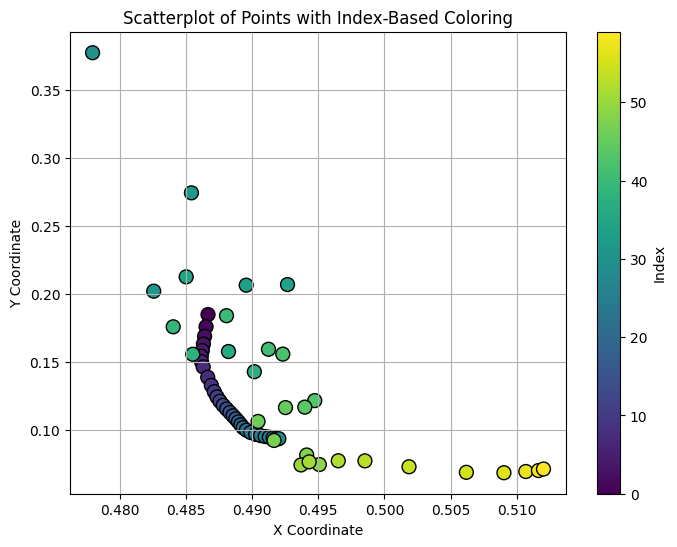

In [325]:
import matplotlib.pyplot as plt
import numpy as np

item = next(iter(eval_loader)).squeeze(0)[0][:30]
item.shape

with torch.no_grad():
    predicted = trained_model(item.to(device))
    
predicted = predicted.squeeze(0).detach().cpu()
plot_data = torch.cat((item, predicted), dim=0)

# Extract x, y coordinates
x, y = plot_data[:, 0], plot_data[:, 1]

# Generate colors based on indices
colors = np.arange(len(plot_data))

# Create scatter plot
plt.figure(figsize=(8, 6))
scatter = plt.scatter(x, y, c=colors, cmap='viridis', s=100, edgecolor='k')

# Add colorbar
plt.colorbar(scatter, label="Index")

# Add labels and grid
plt.xlabel("X Coordinate")
plt.ylabel("Y Coordinate")
plt.title("Scatterplot of Points with Index-Based Coloring")
plt.grid(True)
plt.show()